# **STAT-201 Project Report**

## Comparison of crime rates before and after the outbreak of COVID-19 in Vancouver, Canada
Zicheng Zhao, Shariq Imran Hassan, Yandong Huang, Wenhan Zhang

## Introduction
Crime rates are one of the key indicators of community safety, and major social events such as political change and public health emergency of international concern can have the potential to impact and destabilize crime rates.

Based on the most recent major health emergency event: COVID-19, we will use the time point of this outbreak, i.e. Early 2020, as the dividing line, to compare the crime rates in Vancouver **three years ago (2017-2019)** and **three years later (2020-2022)**.

### Research Question
In this project, the main question which we want to figure out is:
#### `Whether crime rate was influenced by the outbreak of COVID-19 and which types of crime have abnormal fluctuations that need people to pay attention on?`

### Dataset
Our dataset contains crime information in Vancouver (all regions covered according to `VPD Open Data`) from 2017-2022, and including information such as:
- `TYPE`: The type of crime activities.
- `YEAR`, `MONTH`, `DAY`, `HOUR`, `MINUTE`: The time when the reported crime activity occured. (Based on the finding of the police investigation.)
- `HUNDRED_BLOCK`: Generalized location of the reported crime activity.
- `NEIGHBOURHOOD`: The name of the neighbourhood where the location of the reported crime activity was belonged to.
- `X`, `Y`: Coordinate Values. 


For more information, please take a look at the website: https://vpd.ca/

# Preliminary Results

First, we need to load the necessary libraries:

In [4]:
library(tidyverse)
library(GGally)
library(tidymodels)
library(broom)
library(repr)
library(infer)
library(ggplot2)
library(tidyr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.1     ✔ rsample      1.1.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.3     ✔ workflows    1.0.0
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.1     ✔ yardstick    1.1.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  mas

## 1. Loading the dataset

We first downloaded the dataset to our repository and read it from there as we cannot read datasets' directly from vpd's website.

Then the next thing we do is to take a glance at the dataset to see what it looks like.

In [5]:
crime <- read.csv("crime_data/merged_csv_files.csv")
head(crime)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Theft from Vehicle,2017,8,29,21,30,19XX TURNER ST,Grandview-Woodland,495232.4238,5458486.6121
2,Theft from Vehicle,2017,12,25,21,0,19XX UPLAND DR,Victoria-Fraserview,495089.4532,5451695.1098
3,Theft from Vehicle,2017,3,24,22,30,19XX VENABLES ST,Grandview-Woodland,495231.0367,5458207.3987
4,Theft from Vehicle,2017,10,23,9,22,19XX VENABLES ST,Grandview-Woodland,495231.0367,5458207.3987
5,Theft from Vehicle,2017,7,3,21,0,19XX W 11TH AVE,Kitsilano,489210.9151,5456573.0018
6,Theft from Vehicle,2017,11,10,16,0,19XX W 11TH AVE,Kitsilano,489210.9151,5456573.0018


**Table 1:** Preview of the crime data dataset to be analyzed.

## 2. Cleaning and Wrangling Data

We first need to clean the data and get rid of any NA values our datset might have. Therefore, now we filter out any NA data in the specific columns we feel we might need to analyze in our model. The `YEAR` column had an unusual string type which we needed to be adressed and changed as well. 

Since we are also only focusing on the years from 2017 to 2022 (COVID Timeline), we subset the `YEAR` column.

In [19]:
# Filter NA from dataset and 2017<=YEAR<=2022
crime <- crime %>%
        filter(!is.na(NEIGHBOURHOOD)) %>%
        filter(!(YEAR == "YEAR")) %>%
        filter(!is.na(YEAR)) %>%
        filter(!is.na(MONTH)) %>%
        filter(!is.na(TYPE)) %>%
        subset(YEAR >= 2017 & YEAR <= 2022)
head(crime)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Theft from Vehicle,2017,8,29,21,30,19XX TURNER ST,Grandview-Woodland,495232.4238,5458486.6121
2,Theft from Vehicle,2017,12,25,21,0,19XX UPLAND DR,Victoria-Fraserview,495089.4532,5451695.1098
3,Theft from Vehicle,2017,3,24,22,30,19XX VENABLES ST,Grandview-Woodland,495231.0367,5458207.3987
4,Theft from Vehicle,2017,10,23,9,22,19XX VENABLES ST,Grandview-Woodland,495231.0367,5458207.3987
5,Theft from Vehicle,2017,7,3,21,0,19XX W 11TH AVE,Kitsilano,489210.9151,5456573.0018
6,Theft from Vehicle,2017,11,10,16,0,19XX W 11TH AVE,Kitsilano,489210.9151,5456573.0018


**Table 2:** Preview of the cleaned and filtered crime data dataset.

Now we would like to see the different `TYPE`'S of crime we have and its number of occurences from 2017 to 2022.

In [17]:
# Filter for TYPE of data and number of occurences
crime_type <- crime %>%
    group_by(TYPE) %>%
    summarize(n = n())

crime_type

TYPE,n
<chr>,<int>
Break and Enter Commercial,13553
Break and Enter Residential/Other,11953
Homicide,93
Mischief,34042
Offence Against a Person,21087
Other Theft,63346
Theft from Vehicle,70143
Theft of Bicycle,11554
Theft of Vehicle,6623


**Table 3:** Preview of `TYPE` and number of occurences of each crime (2017 - 2022)

Here we can see that we have 11 different categories for crime with the most occurences being 'Theft from Vehicle (70143)', and the least being 'Vehicle Collision or Pedestrian Struck (with Fatality) (87)'. Since we would like to be specific in our results, we choose not to combine similar `TYPE`'s of crime such as 'Break and Enter Commercial' and 'Break and Enter Residential/Other' for one example. 

## 3. Plots

Now we can do a simple comparison of overall general crime rates in different years from 2017-2022 to see its general tendency.

YEAR,CRIME
<chr>,<int>
2017,43214
2018,44266
2019,48144
2020,37506
2021,32189
2022,34189


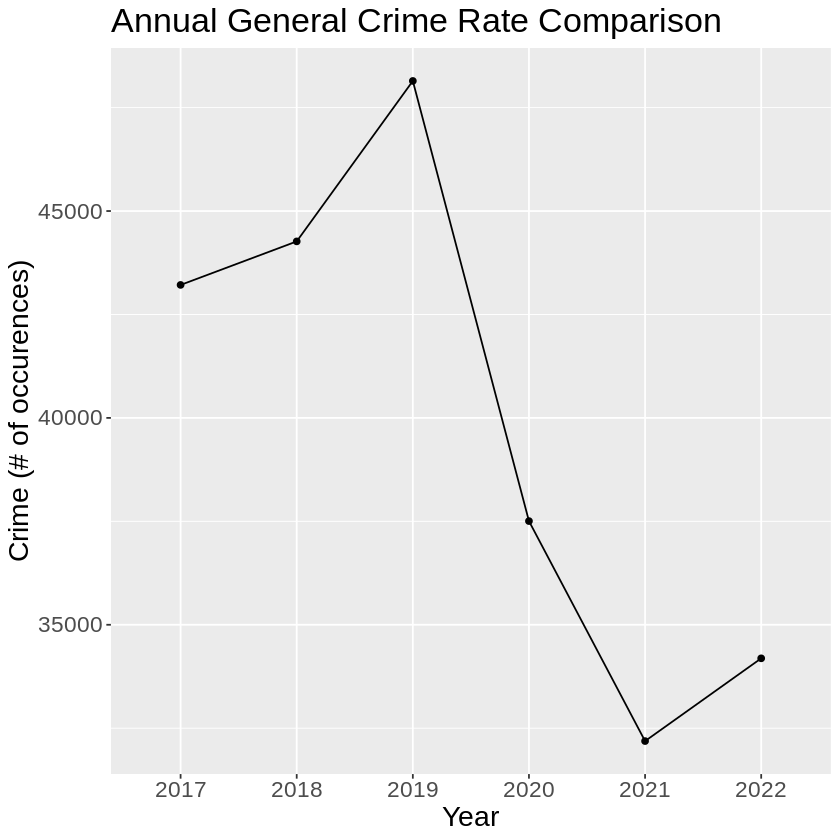

In [29]:
# Group Data by YEAR 
annual_general_crime <- crime %>%
               group_by(YEAR) %>%
               summarise(CRIME = n())

# Plot Annual Crime Data vs. Year
annual_general_crime_plot <- annual_general_crime %>%
               ggplot(aes(x = YEAR, y = CRIME, group = 1)) +
               geom_line() +
               geom_point() +
               ggtitle("Annual General Crime Rate Comparison") +
               labs(x = "Year", y = "Crime (# of occurences)") +
               theme(text = element_text(size = 17))

annual_general_crime
annual_general_crime_plot

**Figure 1:** Line Graph for Number of Crimes vs Year.

From the visualized plot above, we can observe that since the outbreak of COVID-19 occurred in 2019, the general crime ratio had a precipitous fall. We assume that the pandemic restricted people's activities and interactions and increased a sense of health and safety over crime.

Continuously, according to the background of the pandemic, we would do analysis on specific `TYPE`'s of crime, and at specific locations, `NEIGHBOURHOOD`.
Therefore, we would first filter out the columns not required to simplify the chart.
**CHECK**

In [35]:
# Select Required Columns
crime <- crime %>%
     select(TYPE, YEAR, MONTH, DAY, NEIGHBOURHOOD)

head(crime)

,TYPE,YEAR,MONTH,DAY,NEIGHBOURHOOD
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Theft from Vehicle,2017,8,29,Grandview-Woodland
2,Theft from Vehicle,2017,12,25,Victoria-Fraserview
3,Theft from Vehicle,2017,3,24,Grandview-Woodland
4,Theft from Vehicle,2017,10,23,Grandview-Woodland
5,Theft from Vehicle,2017,7,3,Kitsilano
6,Theft from Vehicle,2017,11,10,Kitsilano


**Table 4:** Now we have a dataframe with the required columns.

### Comparing Crime Rates of Different `TYPE`'s before and during COVID

Next, we would visualize our dataframe by grouping by `TYPE` and `YEAR` to observe which type of crime happened more frequently.

For the column `YEAR`, because we treat the outbreak of COVID-19 as the time point, we would combine the data of 2017-2019, and 2020-2022 together respectively.

In [36]:
# Refactor `YEAR` column into `COVID_OUTBREAK` column
out_break <- crime %>%
    mutate(COVID_OUTBREAK = case_when(
        YEAR <= 2019 ~ "Before_COVID",
        YEAR >= 2020 ~ "During_COVID"
    ))

# Group by `TYPE` and `COVID_OUTBREAK` for analysis
criming <- out_break %>%
    group_by(TYPE, COVID_OUTBREAK) %>%
    count() %>%
    spread(key = TYPE, value = n, fill = 0)

transposed_crime <- t(criming)

transposed_crime

COVID_OUTBREAK,Before_COVID,During_COVID
Break and Enter Commercial,6702,6851
Break and Enter Residential/Other,7114,4839
Homicide,44,49
Mischief,16920,17122
Offence Against a Person,9716,11371
Other Theft,35382,27964
Theft from Vehicle,44956,25187
Theft of Bicycle,6590,4964
Theft of Vehicle,4019,2604
Vehicle Collision or Pedestrian Struck (with Fatality),41,46


**Table 5:** Before and During COVID crime rates' of different `TYPE`'s

Now we get the general data of the amount of each type of crime before covid and after covid, and we can visualize them to do a comparison and observe which `TYPE` has an abnormal change.

Now the data is generally clean, and we can explore the dataset more!

**CHECK**

## 4. Exploring the dataset

In [ ]:
# Set seed for Reproducible Analysis
set.seed(123)

# Transfomr criming into DF
frame_crime <- as.data.frame(criming)

frame_crime_long <- pivot_longer(frame_crime, 
                                 -COVID_OUTBREAK,
                                 names_to = "Crime",
                                 values_to = "Value")

diff_crime_plot <- frame_crime_long %>%
    ggplot(aes(x = Crime, y = Value, fill = COVID_OUTBREAK)) +
    geom_bar(stat = "identity", position = "dodge") +
    scale_fill_manual(values = c("red", "blue")) +
    labs(x = "Crime", y = "Amount", fill = "COVID_OUTBREAK") +
    ggtitle("Different crime types' comparison") +
    theme(axis.text.x = element_text(angle = 75, vjust = 1, hjust = 1),
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 15))

options(repr.plot.width = 20, repr.plot.height = 20)

diff_crime_plot

As we can see from the bar plot above, the ratio of different crime types are generally decreasing, while some of them were increasing instead.

Among these types which have abnormal change, we would like to see the one with the biggest incresing first: `Offence Against a Person`.

In [53]:
crime_for_offence <- crime %>%
    filter(TYPE == "Offence Against a Person") %>%
    select('YEAR','MONTH', 'DAY', 'NEIGHBOURHOOD')

head(crime_for_offence)

,YEAR,MONTH,DAY,NEIGHBOURHOOD
,<chr>,<chr>,<chr>,<chr>
1,2017,7,1,West End
2,2017,2,14,West End
3,2017,5,28,West End
4,2017,9,22,West End
5,2017,7,1,West End
6,2017,10,31,West End


Now we convert 'YEAR' and 'MONTH' columns to a date format and seperate the time as before and after the outbreak of COVID-19.

In [54]:
# Transform the time into the Date format
crime_for_offence$DATE <- as.Date(paste(crime_for_offence$YEAR, 
                                        crime_for_offence$MONTH,
                                        "01",
                                        sep = "-"), 
                                  format = "%Y-%m-%d")

# Double check by filtering the date into the range we would target generally.
subset_data <- subset(crime_for_offence, crime_for_offence$DATE >= as.Date("2017-01-01") &
                                         crime_for_offence$DATE <= as.Date("2022-12-31"))

head(crime_for_offence)

# Seperate the dataset into two parts according to the outbreak of COVID-19.
subset_data$OUTBREAK <- ifelse(subset_data$DATE < as.Date("2020-01-01"), 
                               "Before", "After")

head(subset_data)

,YEAR,MONTH,DAY,NEIGHBOURHOOD,DATE
,<chr>,<chr>,<chr>,<chr>,<date>
1,2017,7,1,West End,2017-07-01
2,2017,2,14,West End,2017-02-01
3,2017,5,28,West End,2017-05-01
4,2017,9,22,West End,2017-09-01
5,2017,7,1,West End,2017-07-01
6,2017,10,31,West End,2017-10-01


,YEAR,MONTH,DAY,NEIGHBOURHOOD,DATE,OUTBREAK
,<chr>,<chr>,<chr>,<chr>,<date>,<chr>
1,2017,7,1,West End,2017-07-01,Before
2,2017,2,14,West End,2017-02-01,Before
3,2017,5,28,West End,2017-05-01,Before
4,2017,9,22,West End,2017-09-01,Before
5,2017,7,1,West End,2017-07-01,Before
6,2017,10,31,West End,2017-10-01,Before


Create a frequency table of crimes by month and year and stratified by the period before and after the outbreak of COVID-19, and convert it to a data frame and edit it slightly.

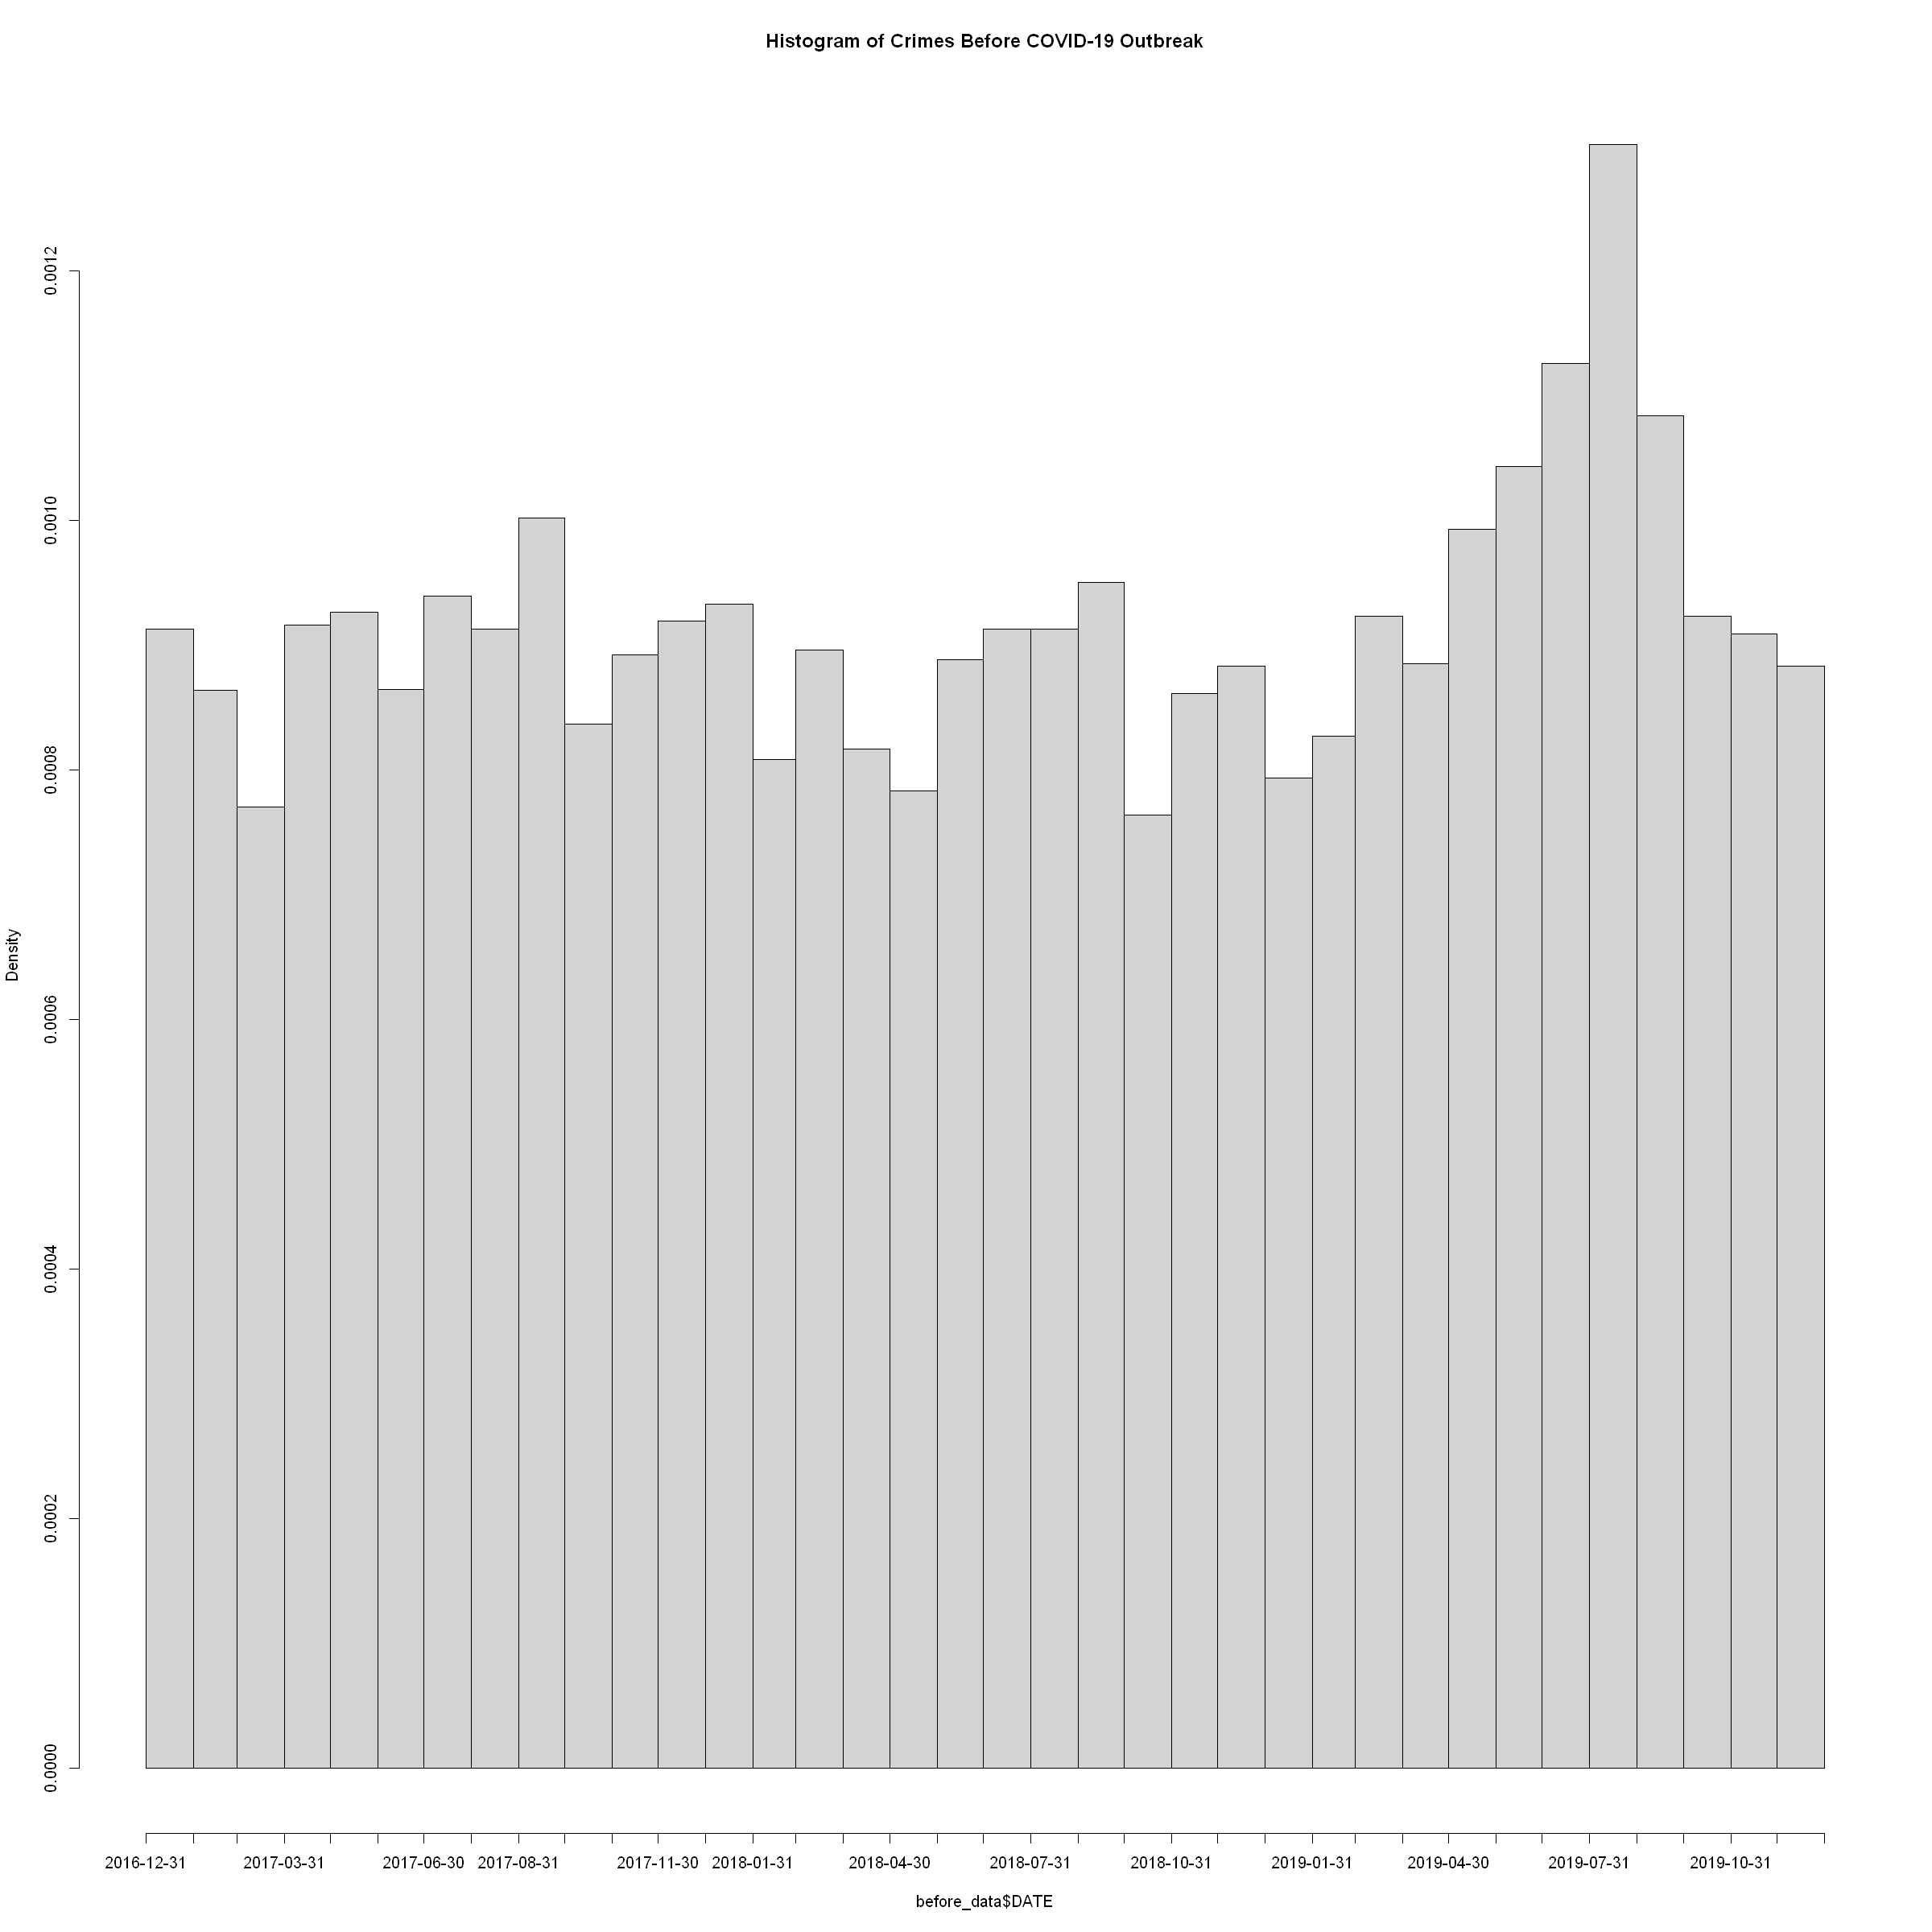

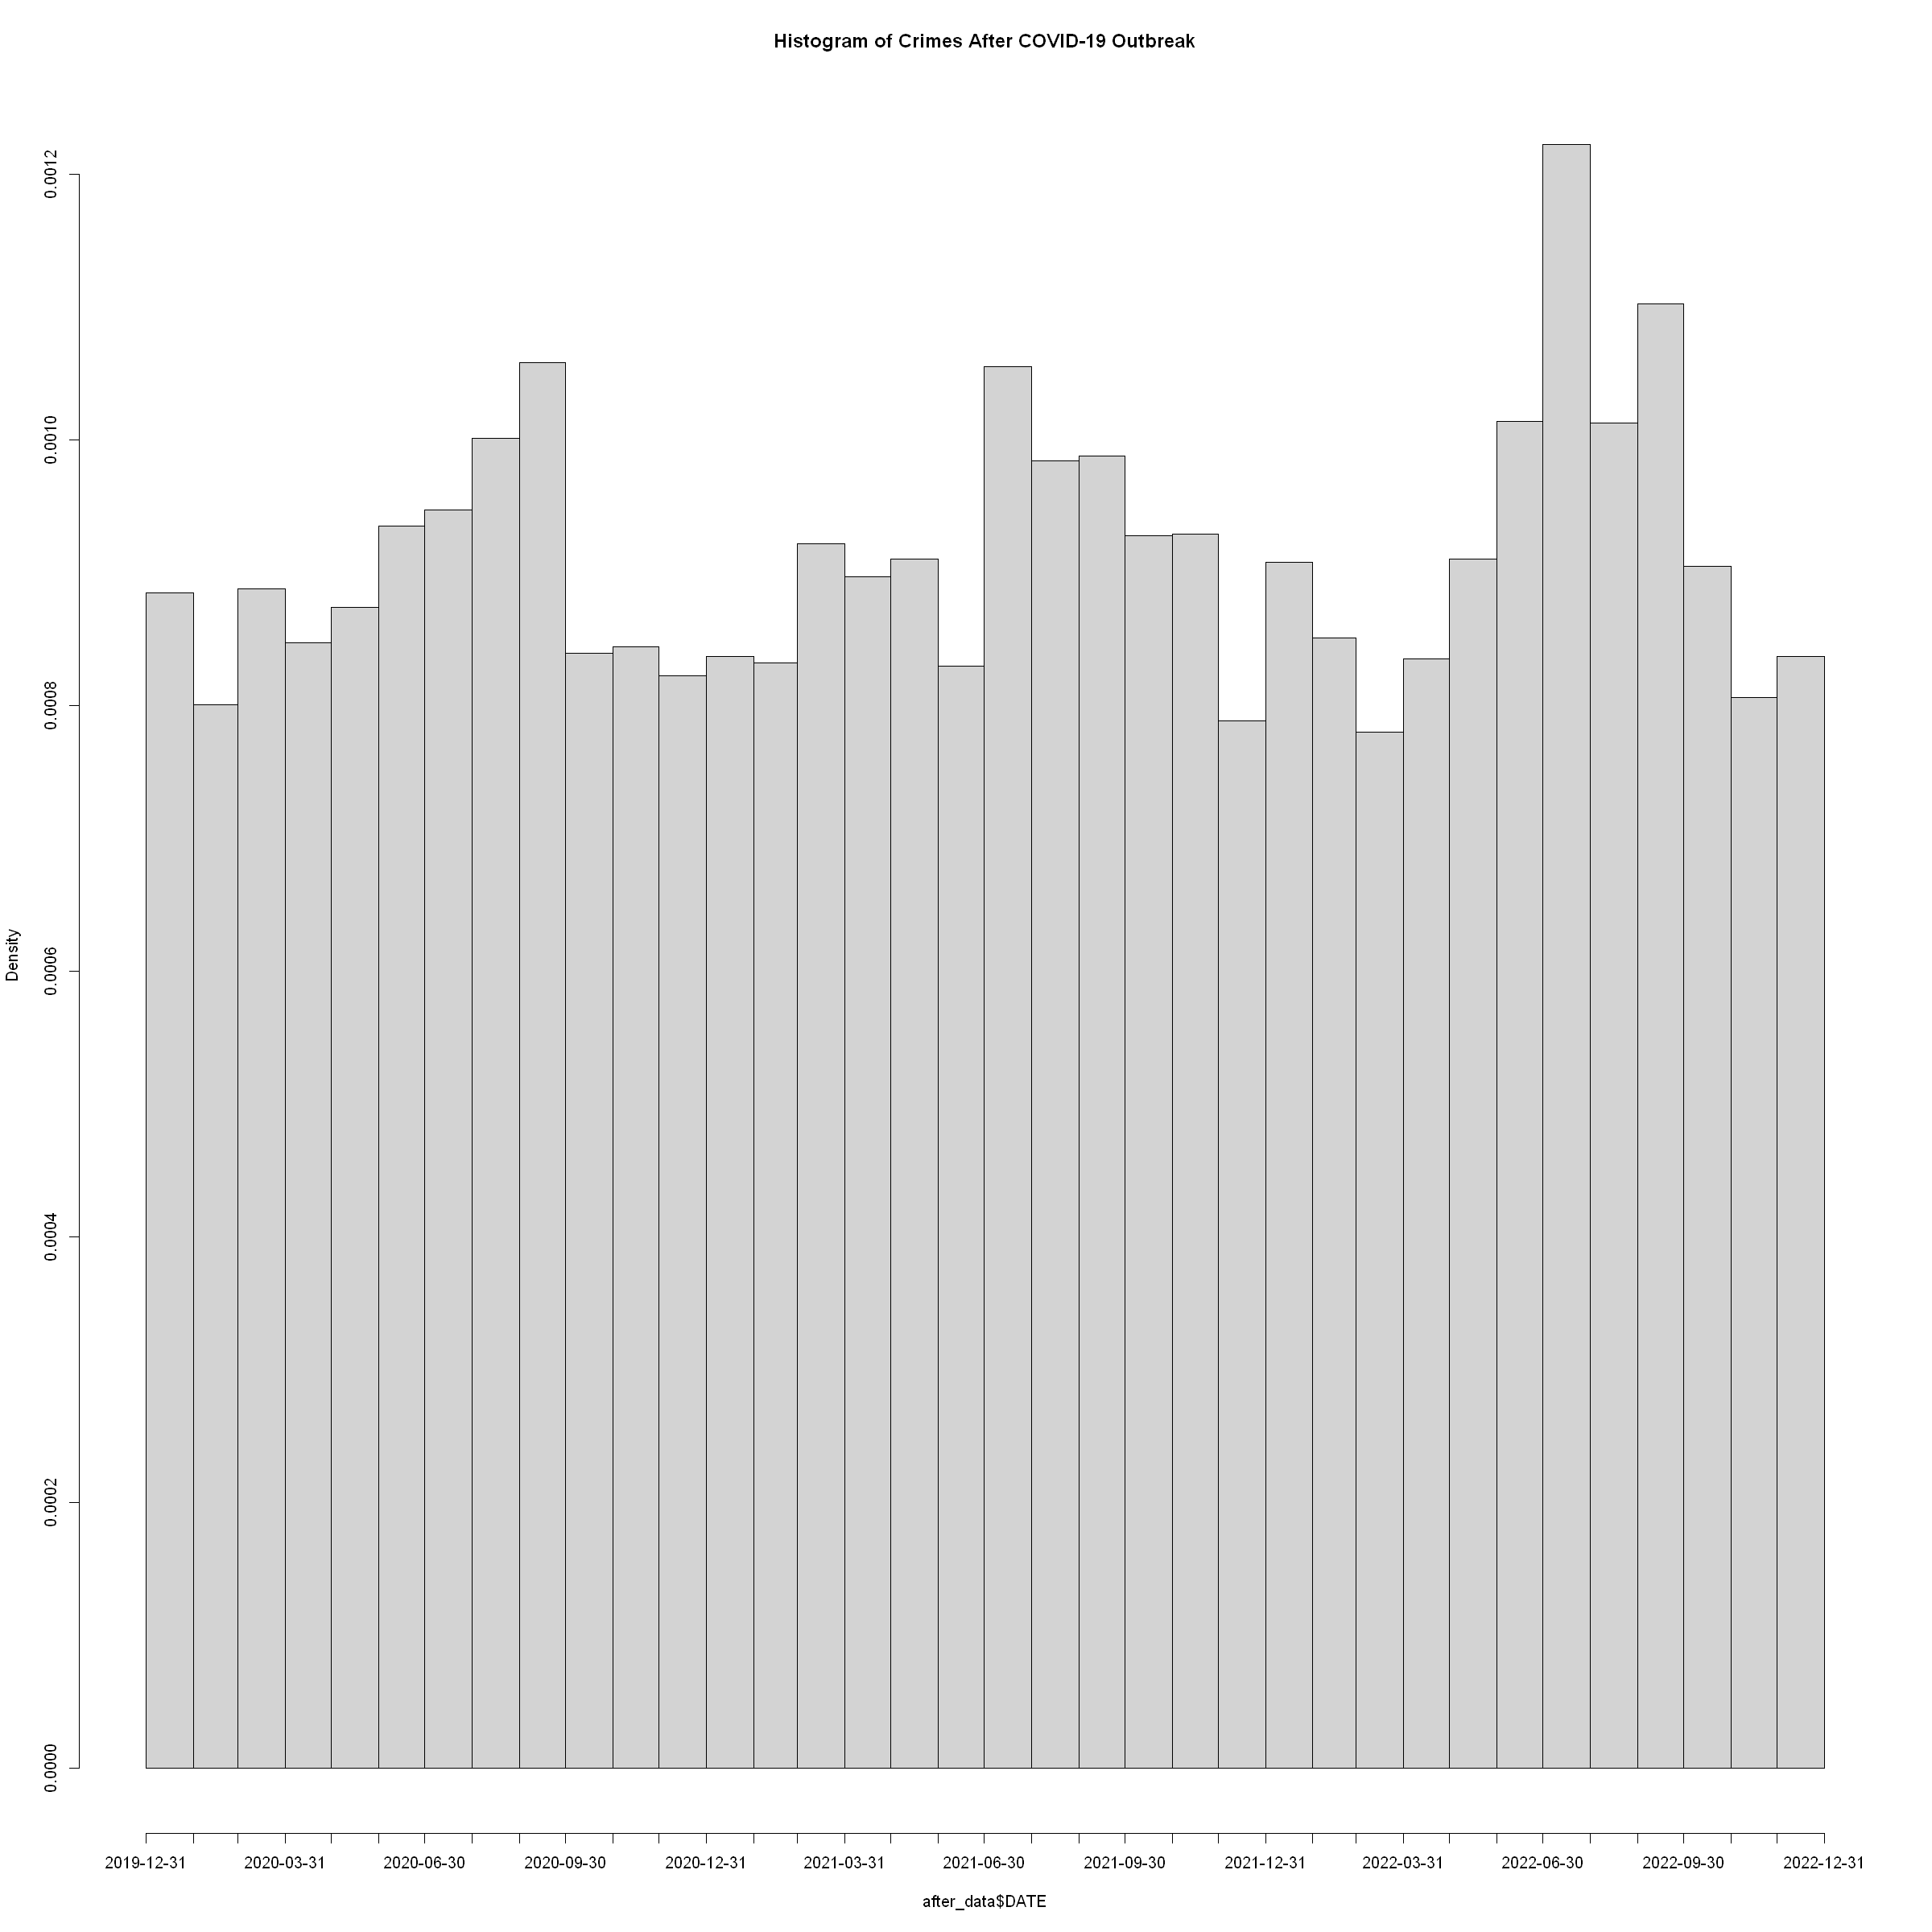

In [76]:
before_data <- subset(subset_data, OUTBREAK == "Before")
after_data <- subset(subset_data, OUTBREAK == "After")

hist(before_data$DATE, breaks = "months", main = "Histogram of Crimes Before COVID-19 Outbreak")
hist(after_data$DATE, breaks = "months", main = "Histogram of Crimes After COVID-19 Outbreak")

## 3. Performing the data analysis

Now we would perform bootstrapping, resampling the data and computing confidence intervals for the means.

In [88]:
library(boot)

In [91]:
# Define a function to compute the mean of a sample
mean_func <- function(data, index) {
    mean(data[index])
}

# Perform bootstrap resampling
before_boot <- boot(before_days, mean_func, R = 1000)
after_boot <- boot(after_days, mean_func, R = 1000)

# Compute the confidence intervals for the means
before_ci <- boot.ci(before_boot, type = "perc")
after_ci <- boot.ci(after_boot, type = "perc")

# Print the confidence intervals
print(before_ci)
print(after_ci)

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = before_boot, type = "perc")

Intervals : 
Level     Percentile     
95%   (543.2, 556.5 )  
Calculations and Intervals on Original Scale
BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = after_boot, type = "perc")

Intervals : 
Level     Percentile     
95%   (533.2, 545.4 )  
Calculations and Intervals on Original Scale


Now let's visualize the bootstrapping distribution of means.

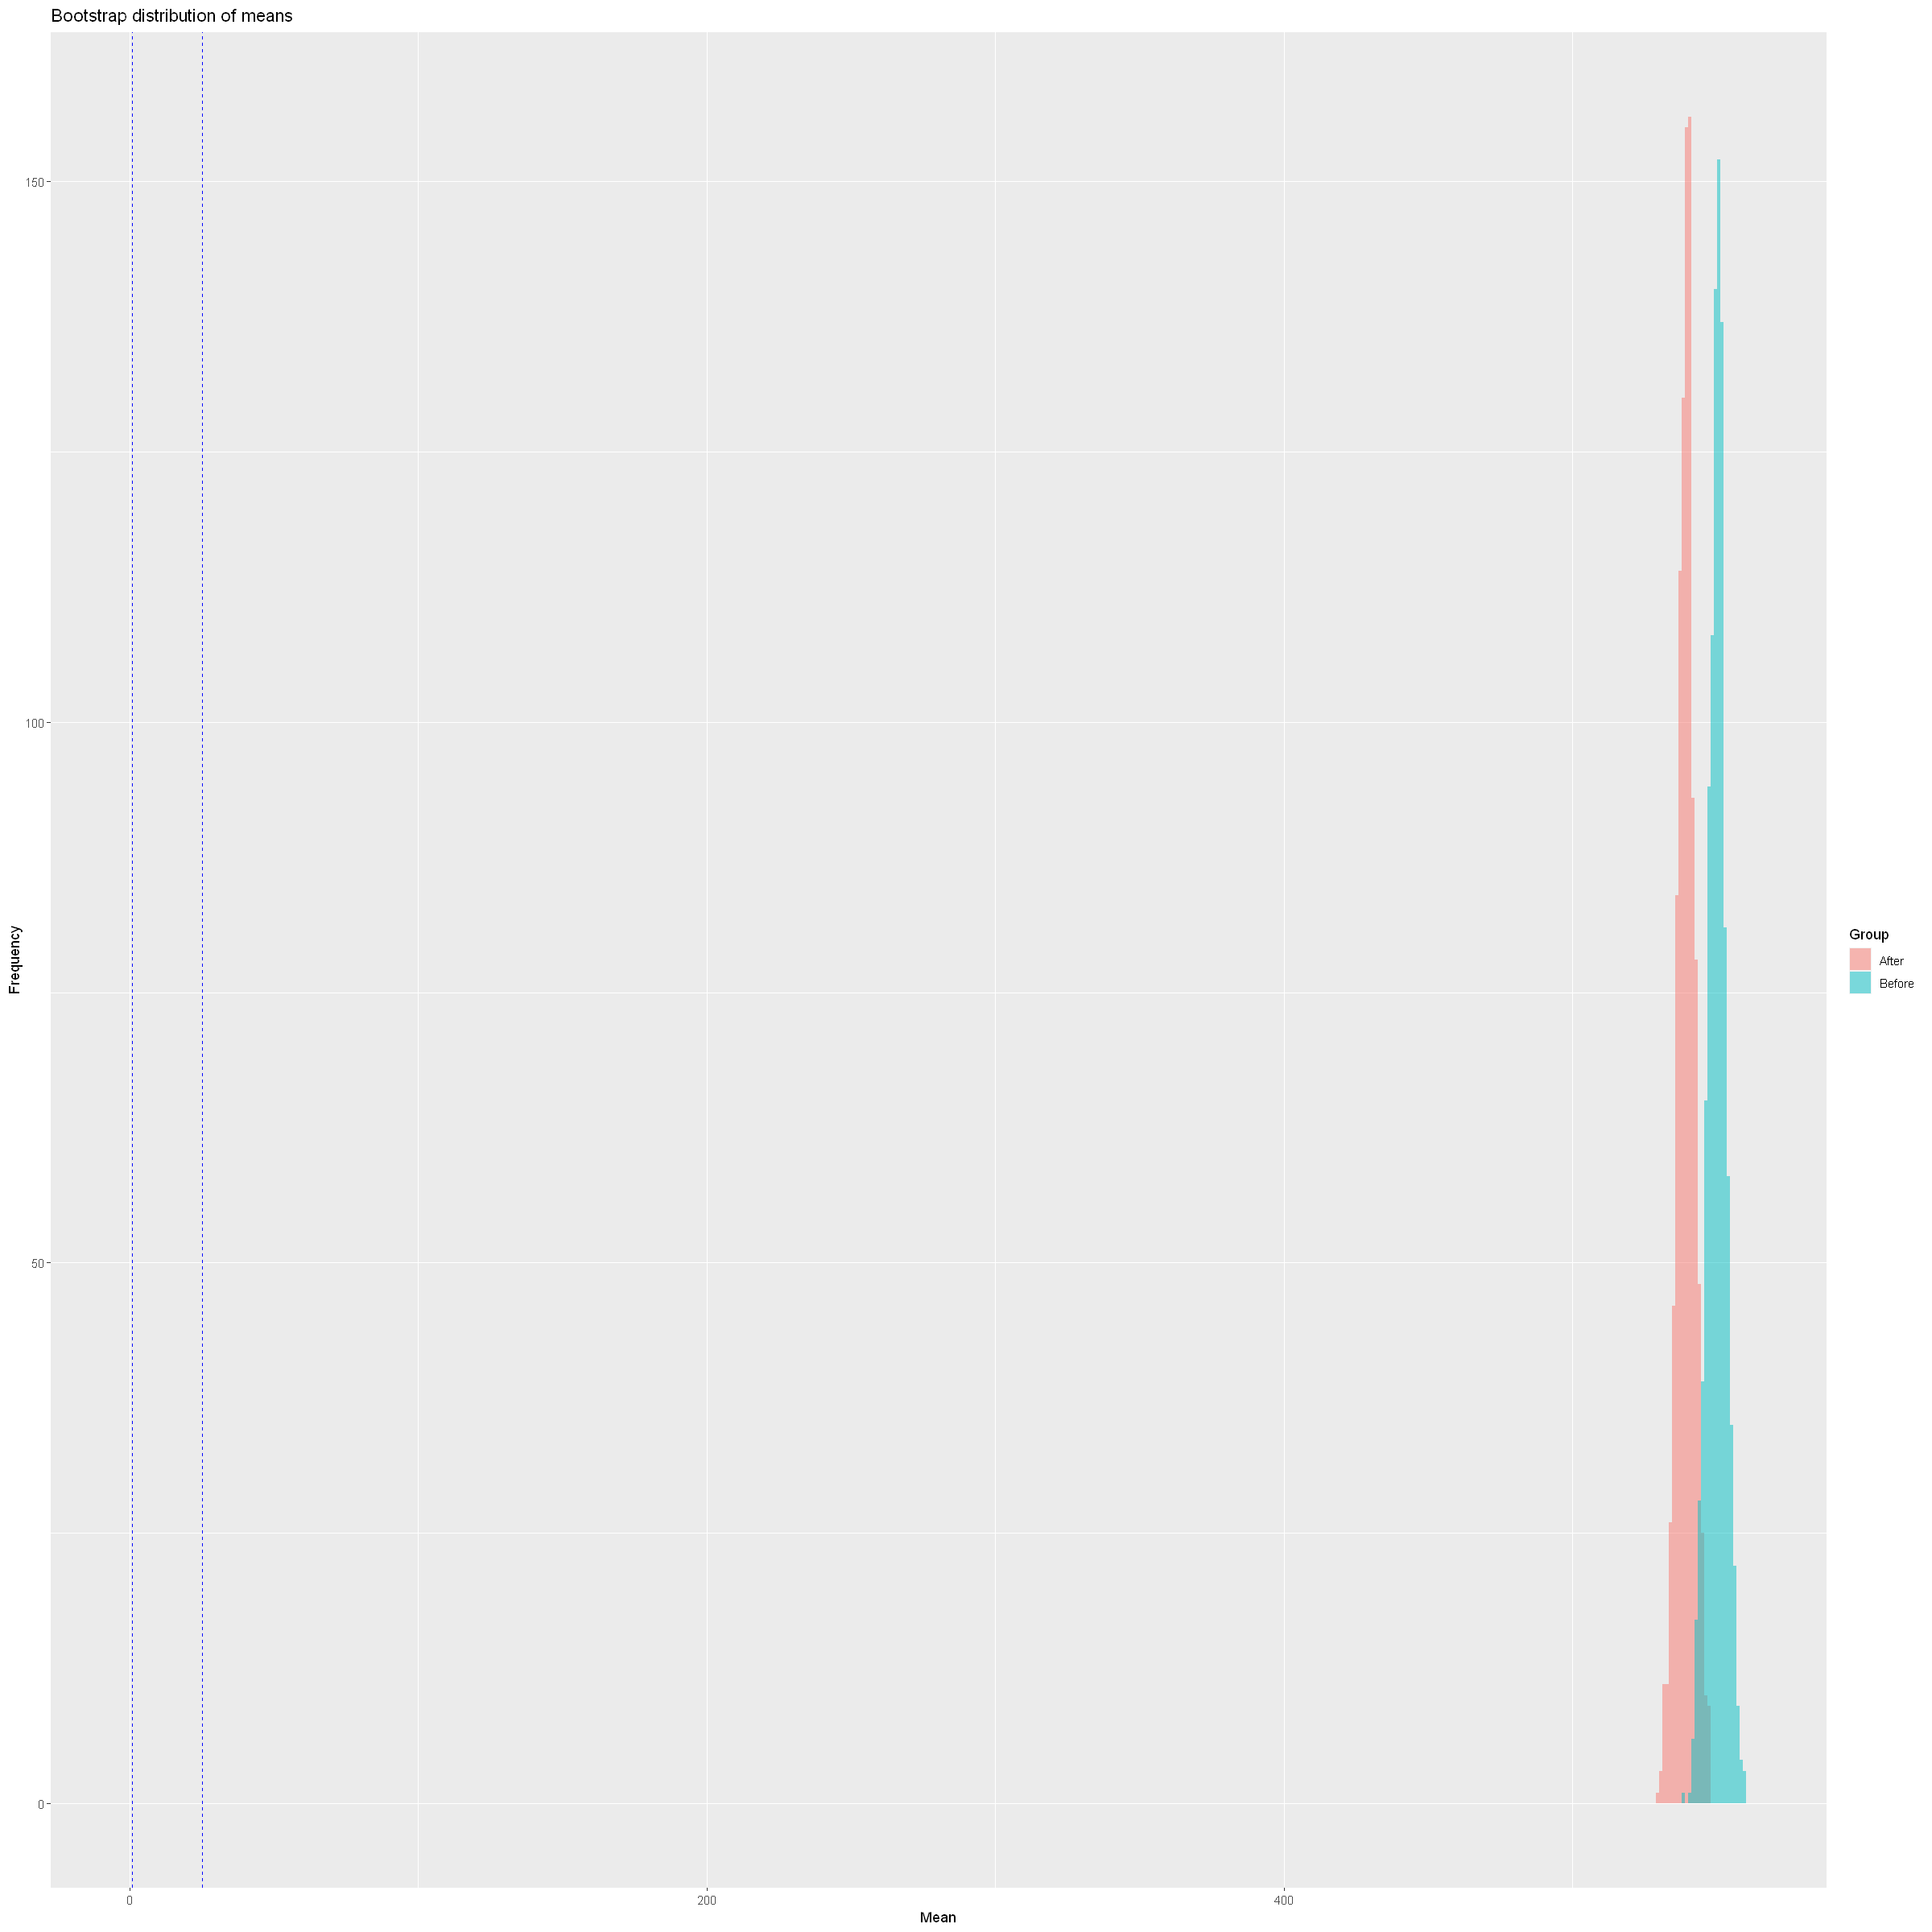

In [99]:
# Create a data frame with the bootstrap means and labels
before_df <- data.frame(value = before_boot$t, group = "Before")
after_df <- data.frame(value = after_boot$t, group = "After")
df <- rbind(before_df, after_df)

# Create a histogram with confidence intervals
ggplot(df, aes(x = value, fill = group)) +
    geom_histogram(alpha = 0.5, position = "identity", bins = 500) +
    geom_vline(xintercept = before_ci$percent[1], linetype = "dashed", color = "red") +
    geom_vline(xintercept = before_ci$percent[2], linetype = "dashed", color = "red") +
    geom_vline(xintercept = after_ci$percent[1], linetype = "dashed", color = "blue") +
    geom_vline(xintercept = after_ci$percent[2], linetype = "dashed", color = "blue") +
    labs(title = "Bootstrap distribution of means",
         x = "Mean",
         y = "Frequency",
         fill = "Group")

According to the graph above, the confidence intervals overlap substantially, it suggests that there may not be a statistically significant difference between the groups being compared.

However, it is not a definitive indication of the presence or absence of a statistically significant difference.

Let's perform hypothesis testing to determine whether there is a significant difference between the distributions of crimes before and after the outbreak.

We will use **t-test**, then **check p-value**.

In [87]:
# Convert the date to a numeric format such as the number of days since a reference date.
before_data$days_since_outbreak <- as.integer(as.Date("2020-01-01") - before_data$DATE)
after_data$days_since_outbreak <- as.integer(after_data$DATE - as.Date("2020-01-01"))

# Extract the filtered date above
before_days <- before_data$days_since_outbreak
after_days <- after_data$days_since_outbreak

# Doing t-test which includes p-value.
t.test(before_days, after_days)


	Welch Two Sample t-test

data:  before_days and after_days
t = 2.4186, df = 20495, p-value = 0.01559
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  2.014768 19.239448
sample estimates:
mean of x mean of y 
 549.9443  539.3172 


From the result above, we can observed that the two-sample t-test is **less than 0.05**, which is 0.01559.

We can **reject the null hypothesis**

Now we can tell that **there is significant difference in the mean frequency of crime** before and after the outbreak of COVID-19.

Now we will try to do the **Hypothesis Test** on :

Compare the frequency of crime from 2017 to 2019 and 2020 to 2022 for each `NEIGHBOURHOOD` and obtain the p-value for each test.

In [ ]:
crime_offence <- crime %>%
    filter(TYPE == "Offence Against a Person") %>%
    filter(NEIGHBOURHOOD != "") %>%
    select(YEAR, NEIGHBOURHOOD)

# Create a new column to indicate whether the crime happened from 2017 to 2019 or 2020 to 2022
crime_offence$period <- ifelse(crime_offence$YEAR %in% c(2017, 2018, 2019), "2017-2019", "2020-2022")

# Get a list of unique neighborhoods
neighborhoods <- unique(crime_offence$NEIGHBOURHOOD)

# Create an empty vector to store the p-values
p_values <- c()

for (n in neighborhoods) {
  # Subset the data for the current neighborhood
  neighborhood_data <- subset(crime_offence, NEIGHBOURHOOD == n)
  
  # Create a contingency table of crime frequency by year and period
  contingency_table <- table(neighborhood_data$YEAR, neighborhood_data$period)
  
  # Conduct a chi-square test of independence to compare the frequency of crime between the two periods
  chi_sq_test <- chisq.test(contingency_table)
  
  # Extract the p-value from the test result
  p_value <- chi_sq_test$p.value
  
  # Add the p-value to the vector
  p_values <- c(p_values, p_value)
}

# Print the p-values for each neighborhood
names(p_values) <- neighborhoods

# Convert the p-values to a data frame
p_values_df <- data.frame(NEIGHBOURHOOD = names(p_values), p_value = p_values)

# Create a tidy format using the gather function
tidy_p_values <- gather(p_values_df, key = "test", value = "p_value", -NEIGHBOURHOOD)

tidy_p_values

Warning message in chisq.test(contingency_table):
"Chi-squared approximation may be incorrect"
Warning message in chisq.test(contingency_table):
"Chi-squared approximation may be incorrect"
Warning message in chisq.test(contingency_table):
"Chi-squared approximation may be incorrect"
Warning message in chisq.test(contingency_table):
"Chi-squared approximation may be incorrect"
Warning message in chisq.test(contingency_table):
"Chi-squared approximation may be incorrect"
Warning message in chisq.test(contingency_table):
"Chi-squared approximation may be incorrect"


NEIGHBOURHOOD,test,p_value
<chr>,<chr>,<dbl>
West End,p_value,0.000000e+00
Stanley Park,p_value,1.358353e-15
Central Business District,p_value,0.000000e+00
Mount Pleasant,p_value,6.453203e-211
Strathcona,p_value,0.000000e+00
Grandview-Woodland,p_value,2.633585e-268
Kensington-Cedar Cottage,p_value,9.060487e-167
Hastings-Sunrise,p_value,5.382466e-119
Renfrew-Collingwood,p_value,1.781760e-173


As we can see from the chart above, according to the p_values for the `NEIGHBOURHOOD`, they are generally super small

It is a strong evidence to support the assumption that the frequency of **Offence Against a Person** had a big fluctuation during the outbreak of COVID-19.

## 4. Wrapping Up

In this proposal, we have these obversations:

- From the chart, we can easily see a decrease in crime in Vancouver during the COVID-19 outbreak.

- There was a decrease in certain types of crime such as theft from vehicles, theft of bicycles, and break and enter residential/other, during the COVID-19 outbreak, compared to before. It is reasonable that as people started social distancing and stayed at home more than before, there is a slim chance that these crimes would take place.

- There was an increase in some types of crime such as mischief, offencing against a person, and theft of other items. It is consistent with what we have experienced. The anxiety caused by quarantine and traveling restrictions makes racial discrimination and biased thoughts toward others easier.

- Overall, the analysis provides a good overview of crime patterns in Vancouver and can be used to inform policy decisions aimed at reducing crime rates in the city.

## Methods: Plan

- What do we expect to find?
    - The fluctuation of the crime rate caused by the outbreak of COVID-19, and specific types of crime need to pay attention to.

- What impact could such findings have?
    - The findings will let people realize the impact that COVID-19 brought to us on the aspect of community security.

- What future questions could this lead to?
    - The project shows the tendency of crime rate when major social events happen, and give people and institutions guidance on how to make precautions and what should we expect.

## References:

- https://www.sfu.ca/research/scholarly-impacts/how-covid-19-lockdowns-affected-crime-vancouver

- https://vpd.ca/

- https://www.cbc.ca/amp/1.6078015